# Quantizing Stable Diffusion for Faster Inference

This notebook investigates how **post-training quantization (PTQ)** can accelerate Stable Diffusion v1.5 while keeping image quality usable.  
We follow the key ideas from **Q-Diffusion: Quantizing Diffusion Models**:

- Focus on quantizing the **UNet noise-prediction model**, the computational bottleneck.
- Use **timestep-aware activation calibration** (collecting min/max activation ranges across diffusion steps).
- Apply **fake quantization** (INT8, INT4, mixed precision) during inference to simulate low-bit execution.

Unlike the original Q-Diffusion implementation, which uses a custom diffusion codebase, 
we apply the same quantization concepts to the HuggingFace Diffusers version of Stable Diffusion v1.5.  
This allows us to perform realistic model-level and system-level analysis while keeping the project 
feasible within the course timeline.  
We evaluate:

- **Latency** (seconds / image)  
- **VRAM usage**  
- **Image quality** (CLIPScore)  
- **System-level performance** using an **M/M/1 queueing model**

This aligns with our project proposal: *“Dynamic quantization policies for Stable Diffusion under varying system loads.”*

In [1]:
# === CELL 1: Environment & device check ===
import torch, platform, os, time
from pprint import pprint

print("Python:", platform.python_version())
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Python: 3.11.14
PyTorch: 2.6.0+cu124
CUDA available: True
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda


In [2]:
# === CELL 2: Install / import core libraries (run once in the env) ===
# If already installed in your msgai-labs env, you can skip pip installs.

# %pip install --upgrade diffusers transformers accelerate safetensors
# %pip install --upgrade scipy pillow

from diffusers import StableDiffusionPipeline
from transformers import logging as hf_logging

import numpy as np
import math
from collections import defaultdict
from contextlib import contextmanager
from typing import Dict, List, Tuple
import gc

hf_logging.set_verbosity_error()
torch.set_grad_enabled(False)

In [3]:
# === CELL 3: Load Stable Diffusion v1.5 (baseline FP16) ===
# Make sure you have access to this model on Hugging Face.
# If needed: huggingface-cli login  (and/or set HF_TOKEN in env)

MODEL_ID = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    safety_checker=None,   # disable for speed/academic use
)
pipe = pipe.to(device)
pipe.enable_attention_slicing("max")  # slight VRAM reduction

print("Pipeline loaded. UNet parameters:", sum(p.numel() for p in pipe.unet.parameters())/1e6, "M")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Pipeline loaded. UNet parameters: 859.520964 M


  0%|          | 0/20 [00:00<?, ?it/s]

Baseline FP16: 2 images, ~8.93 s / image


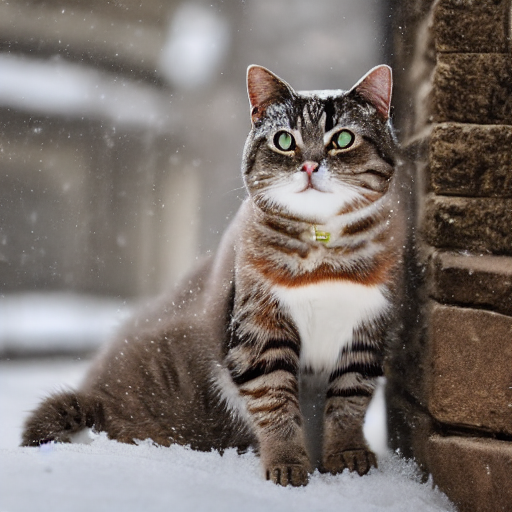

In [4]:
# === CELL 4: Simple image generation + timing helper ===
from PIL import Image
import random

@torch.inference_mode()
def generate_images(
    prompts: List[str],
    num_inference_steps: int = 30,
    guidance_scale: float = 7.5,
    height: int = 512,
    width: int = 512,
    seed: int = 42,
):
    """
    Generate images and measure latency.
    Returns: images, mean_latency_per_image (seconds).
    """
    generator = torch.Generator(device=device)
    generator.manual_seed(seed)

    start = time.perf_counter()
    result = pipe(
        prompts,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        height=height,
        width=width,
        generator=generator,
    )
    end = time.perf_counter()
    images = result.images

    total_time = end - start
    mean_time = total_time / len(prompts)
    return images, mean_time

test_prompts = [
    "a photo of a cat in the snow, high quality, 4k",
    "a futuristic city at night, neon lights, cyberpunk style",
]

imgs, t = generate_images(test_prompts, num_inference_steps=20)
print(f"Baseline FP16: {len(test_prompts)} images, ~{t:.2f} s / image")
display(imgs[0])

## Calibration Procedure and Quantization Modes

### Timestep-Aware Calibration

Before applying quantization, we first calibrate the **UNet activations**:

1. We register forward hooks on every `Conv2d` module inside the UNet.
2. We run the full Stable Diffusion pipeline on a small set of synthetic prompts
   (e.g., surreal scenes) for several diffusion timesteps.
3. For each convolution’s output tensor, we track the **minimum** and **maximum**
   activation values observed across all calibration runs.
4. After calibration, we compute a **per-module activation scale** for a given bit width:
   \[
   \text{scale} = \frac{\max(|\text{min}|, |\text{max}|)}{2^{b-1} - 1}
   \]
   where \(b\) is the number of bits (4 or 8), and we use symmetric quantization.

This corresponds to a simplified, timestep-aware PTQ approach: we expose the network
to a variety of timesteps and prompts so that the recorded activation ranges reflect
real inference usage, as in Q-Diffusion’s calibration step.

### Fake Quantization Hooks (INT8 / INT4 / Mixed)

Instead of changing the model weights on disk, we apply **fake quantization** at runtime:

- For each `Conv2d` in the UNet, we install a forward hook that:
  1. Clamps the activation to the calibrated range \([-Q_{\max} \cdot \text{scale}, Q_{\max} \cdot \text{scale}]\),
  2. Quantizes to integer values via `round(a / scale)`,
  3. Dequantizes back by multiplying with `scale` (so the rest of the pipeline still sees floats).

We support several modes:

- **FP16**  
  No hooks are registered. This is the **baseline** mode used as a reference.

- **INT8**  
  All UNet `Conv2d` outputs are fake-quantized to **8-bit** (symmetric per-tensor), using
  the activation scales learned during calibration.

- **INT4**  
  All UNet `Conv2d` outputs are fake-quantized to **4-bit**. This is a more aggressive setting
  and is expected to **reduce latency / memory** at the cost of quality degradation.

- **Mixed**  
  A simple heuristic policy:
  - Early/downsampling and mid blocks: quantized as **INT8**,
  - Upsampling blocks: quantized as **INT4**.

The mixed mode is a toy version of the idea in Q-Diffusion: more sensitive parts of the network
get higher precision, while less critical blocks are pushed to lower precision for additional speed
or memory savings.

All three quantized modes can be enabled and disabled via a single `quantization_mode(...)`
context manager, making it easy to **benchmark and compare** their impact on latency, memory,
and quality.


In [5]:
# === CELL 5: Collect UNet Conv2d modules (noise estimator) ===
import torch.nn as nn

def collect_unet_conv_modules(unet: nn.Module) -> List[nn.Module]:
    conv_modules = []
    for name, module in unet.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_modules.append((name, module))
    return conv_modules

unet = pipe.unet
conv_modules = collect_unet_conv_modules(unet)
print(f"Found {len(conv_modules)} Conv2d modules in UNet.")
print("First 5:", [name for name, _ in conv_modules[:5]])

Found 98 Conv2d modules in UNet.
First 5: ['conv_in', 'down_blocks.0.attentions.0.proj_in', 'down_blocks.0.attentions.0.proj_out', 'down_blocks.0.attentions.1.proj_in', 'down_blocks.0.attentions.1.proj_out']


In [6]:
# === CELL 6: Timestep-aware activation calibration (Q-Diffusion-style) ===
"""
Goal:
- Run the UNet over multiple timesteps and prompts.
- Record activation min/max for each Conv2d output.
- This approximates the time-step-aware calibration idea from Q-Diffusion
  (we expose the network to activations from different noise levels).
"""

activation_stats: Dict[str, Dict[str, torch.Tensor]] = {
    name: {"min": None, "max": None} for name, _ in conv_modules
}

def _make_calib_hook(name: str):
    def hook(_module, _inputs, output):
        if not torch.is_floating_point(output):
            return
        stats = activation_stats[name]
        out_min = output.min().detach()
        out_max = output.max().detach()
        if stats["min"] is None:
            stats["min"] = out_min
            stats["max"] = out_max
        else:
            stats["min"] = torch.minimum(stats["min"], out_min)
            stats["max"] = torch.maximum(stats["max"], out_max)
    return hook

# Register hooks
hooks = []
for name, module in conv_modules:
    hooks.append(module.register_forward_hook(_make_calib_hook(name)))

print("Calibration hooks registered.")

@torch.inference_mode()
def calibrate_unet(
    num_calib_prompts: int = 16,
    num_inference_steps: int = 20,
):
    """
    Run the full pipeline on some prompts to exercise the UNet at different timesteps.
    We don't need the images; we just want activations through UNet.
    """
    prompts = [
        f"a random object in a surreal landscape #{i}"
        for i in range(num_calib_prompts)
    ]
    _ = pipe(
        prompts,
        num_inference_steps=num_inference_steps,
        guidance_scale=7.5,
        height=512,
        width=512,
    )

    # Move stats to CPU and convert to floats
    for name in activation_stats:
        for key in ["min", "max"]:
            if activation_stats[name][key] is not None:
                activation_stats[name][key] = activation_stats[name][key].cpu().float()

    print("Calibration completed.")

calibrate_unet(num_calib_prompts=8, num_inference_steps=20)

# Remove calibration hooks (we'll add quantization hooks later)
for h in hooks:
    h.remove()
print("Calibration hooks removed.")

Calibration hooks registered.


  0%|          | 0/20 [00:00<?, ?it/s]

Calibration completed.
Calibration hooks removed.


In [7]:
# === CELL 7: Build per-module activation scales for n-bit quantization ===
"""
We use symmetric per-tensor activation quantization:

scale = max(|min|, |max|) / (2^(bits-1) - 1)

Later we will quantize-dequantize outputs:

a_q = round(clamp(a / scale, -Qmax, Qmax)) * scale
"""

def build_activation_scales(n_bits: int) -> Dict[str, float]:
    qmax = 2 ** (n_bits - 1) - 1
    scales = {}
    for name, stats in activation_stats.items():
        if stats["min"] is None or stats["max"] is None:
            # fallback if module wasn't hit in calibration
            scales[name] = 1.0
            continue
        m = float(stats["min"])
        M = float(stats["max"])
        max_abs = max(abs(m), abs(M))
        if max_abs < 1e-8:
            scales[name] = 1.0
        else:
            scales[name] = max_abs / qmax
    return scales

act_scales_int8 = build_activation_scales(8)
act_scales_int4 = build_activation_scales(4)

print("Example INT8 scales for first 5 convs:")
for name in list(act_scales_int8.keys())[:5]:
    print(name, "->", act_scales_int8[name])

Example INT8 scales for first 5 convs:
conv_in -> 0.10654527559055119
down_blocks.0.attentions.0.proj_in -> 0.05216535433070866
down_blocks.0.attentions.0.proj_out -> 0.08981299212598425
down_blocks.0.attentions.1.proj_in -> 0.04013902559055118
down_blocks.0.attentions.1.proj_out -> 0.06329970472440945


In [8]:
# === CELL 8: Attach fake-quantization hooks for INT8 / INT4 / mixed precision ===
"""
We now implement a context manager that:
- registers forward hooks that quantize-dequantize Conv2d outputs
- simulates INT8 / INT4 effects on activations, inspired by Q-Diffusion's PTQ design.
"""

def _make_quant_hook(name: str, n_bits: int, scales_dict: Dict[str, float]):
    qmax = 2 ** (n_bits - 1) - 1
    scale = scales_dict.get(name, 1.0)

    def hook(_module, _inputs, output):
        if not torch.is_floating_point(output):
            return output
        # symmetric fake quantization
        max_abs = qmax * scale
        out_clamped = torch.clamp(output, -max_abs, max_abs)
        out_int = torch.round(out_clamped / scale)
        return out_int * scale
    return hook

@contextmanager
def quantization_mode(
    mode: str = "fp16",
    int8_scales: Dict[str, float] = None,
    int4_scales: Dict[str, float] = None,
):
    """
    mode in {"fp16", "int8", "int4", "mixed"}.

    - fp16: no hooks (base pipeline).
    - int8: fake quantize all Conv2d activations to 8-bit.
    - int4: fake quantize all Conv2d activations to 4-bit.
    - mixed: example policy: int8 for early/down blocks, int4 for mid/up blocks.
    """
    hooks = []

    if mode == "fp16":
        # no hooks, just yield
        yield
        return

    for name, module in conv_modules:
        if "conv" not in name:
            # soft filter, but we already know these are convs
            pass

        if mode == "int8":
            h = module.register_forward_hook(
                _make_quant_hook(name, 8, int8_scales)
            )
            hooks.append(h)

        elif mode == "int4":
            h = module.register_forward_hook(
                _make_quant_hook(name, 4, int4_scales)
            )
            hooks.append(h)

        elif mode == "mixed":
            # Simple heuristic: down_blocks + mid -> int8, up_blocks -> int4
            if "up_blocks" in name:
                h = module.register_forward_hook(
                    _make_quant_hook(name, 4, int4_scales)
                )
            else:
                h = module.register_forward_hook(
                    _make_quant_hook(name, 8, int8_scales)
                )
            hooks.append(h)

    try:
        yield
    finally:
        for h in hooks:
            h.remove()

## Benchmarking Latency and VRAM

For each quantization mode (FP16, INT8, INT4, mixed), we run Stable Diffusion on a fixed set of prompts and measure:

- **Latency** (seconds per image)
- **Peak VRAM usage**
- **Visual comparison of sample outputs**

These metrics allow us to quantify the trade-offs introduced by quantization.


=== Benchmarking mode: fp16 ===


  0%|          | 0/20 [00:00<?, ?it/s]

Mode=fp16 | mean time per image = 7.62s | peak VRAM ≈ 4501.5 MB

=== Benchmarking mode: int8 ===


  0%|          | 0/20 [00:00<?, ?it/s]

Mode=int8 | mean time per image = 10.30s | peak VRAM ≈ 4501.5 MB

=== Benchmarking mode: int4 ===


  0%|          | 0/20 [00:00<?, ?it/s]

Mode=int4 | mean time per image = 6.84s | peak VRAM ≈ 4501.5 MB

=== Benchmarking mode: mixed ===


  0%|          | 0/20 [00:00<?, ?it/s]

Mode=mixed | mean time per image = 7.93s | peak VRAM ≈ 4501.5 MB

=== Summary ===
{'fp16': {'latency': 7.617708324999967,
          'sample_image': <PIL.Image.Image image mode=RGB size=512x512 at 0x20E07DEB2D0>,
          'vram_mb': 4501.4580078125},
 'int4': {'latency': 6.844007250000004,
          'sample_image': <PIL.Image.Image image mode=RGB size=512x512 at 0x20E07F86350>,
          'vram_mb': 4501.4580078125},
 'int8': {'latency': 10.296936000000073,
          'sample_image': <PIL.Image.Image image mode=RGB size=512x512 at 0x20E095A1B50>,
          'vram_mb': 4501.4580078125},
 'mixed': {'latency': 7.929768449999983,
           'sample_image': <PIL.Image.Image image mode=RGB size=512x512 at 0x20E0AAA9490>,
           'vram_mb': 4501.4580078125}}


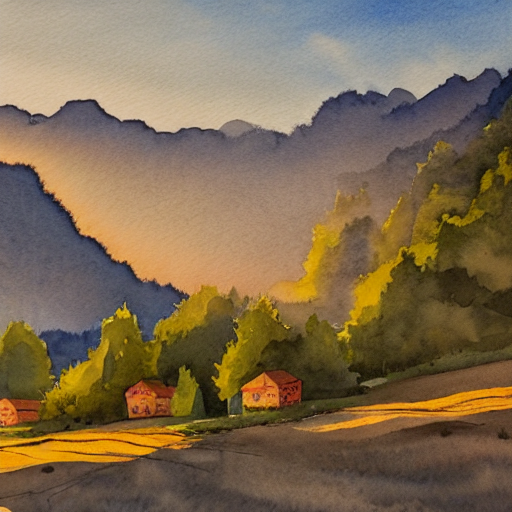

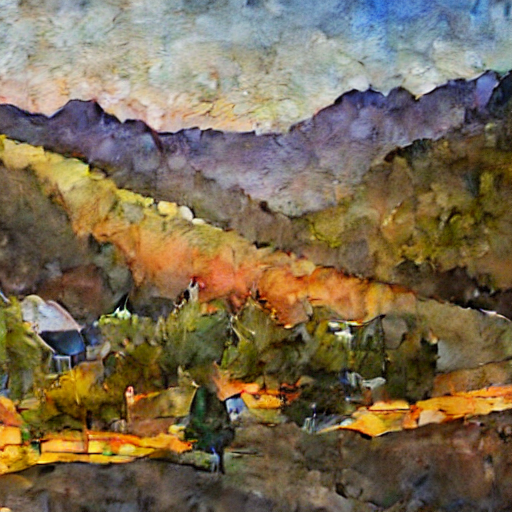

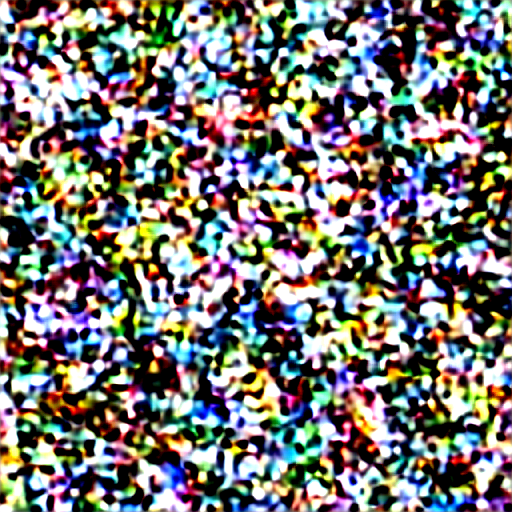

In [9]:
# === CELL 9: Benchmark function for different "quantization" modes ===
import psutil

def get_vram_mb():
    if torch.cuda.is_available():
        return torch.cuda.max_memory_allocated() / (1024 ** 2)
    return 0.0

def reset_vram():
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def benchmark_mode(mode: str, prompts: List[str], steps: int = 20):
    print(f"\n=== Benchmarking mode: {mode} ===")
    reset_vram()

    with quantization_mode(
        mode=mode,
        int8_scales=act_scales_int8,
        int4_scales=act_scales_int4,
    ):
        images, mean_time = generate_images(
            prompts,
            num_inference_steps=steps,
            guidance_scale=7.5,
        )

    vram = get_vram_mb()
    print(f"Mode={mode} | mean time per image = {mean_time:.2f}s | peak VRAM ≈ {vram:.1f} MB")
    return images, mean_time, vram

prompts_eval = [
    "a watercolor painting of a mountain village at sunrise",
    "a realistic portrait of a young woman in natural light",
    "a spaceship landing on Mars in cinematic style",
    "a cozy living room interior, Scandinavian design",
]

results = {}
for mode in ["fp16", "int8", "int4", "mixed"]:
    imgs_mode, t_mode, vram_mode = benchmark_mode(mode, prompts_eval, steps=20)
    results[mode] = {
        "latency": t_mode,
        "vram_mb": vram_mode,
        "sample_image": imgs_mode[0],
    }

print("\n=== Summary ===")
pprint(results)

display(results["fp16"]["sample_image"])
display(results["int8"]["sample_image"])
display(results["int4"]["sample_image"])

## Image Quality Evaluation with CLIPScore

To estimate semantic fidelity after quantization, we compute **CLIPScore** between:

- the prompt text, and
- the generated image.

CLIPScore is not a full replacement for FID, but it is a useful lightweight proxy for image–text alignment.

We evaluate CLIPScore for FP16, INT8, and INT4 modes.

In [10]:
# === CELL 10: Simple "quality" proxy with CLIPScore (optional) ===
"""
For a full project you wanted FID + CLIPScore. Full FID setup is heavy.
As a lighter proxy, we can compute CLIPScore between prompt and image
for each mode and compare averages.

You can keep this as optional if runtime is too long.
"""

# %pip install --upgrade torchmetrics

from torchmetrics.multimodal import CLIPScore
from torchvision import transforms

clip_score = CLIPScore(model_name_or_path="openai/clip-vit-base-patch32").to(device)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def compute_clip_scores(prompts: List[str], images: List[Image.Image]):
    scores = []
    for p, img in zip(prompts, images):
        img_t = preprocess(img).unsqueeze(0).to(device)
        s = clip_score(img_t, [p])
        scores.append(float(s.cpu()))
    return scores

clip_results = {}
for mode in ["fp16", "int8", "int4"]:
    with quantization_mode(
        mode=mode,
        int8_scales=act_scales_int8,
        int4_scales=act_scales_int4,
    ):
        imgs_mode, _ = generate_images(prompts_eval, num_inference_steps=20)
    scores = compute_clip_scores(prompts_eval, imgs_mode)
    clip_results[mode] = {
        "scores": scores,
        "mean": float(np.mean(scores)),
        "std": float(np.std(scores)),
    }

print("\n=== CLIPScore summary (higher is better) ===")
pprint(clip_results)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


=== CLIPScore summary (higher is better) ===
{'fp16': {'mean': 20.059532642364502,
          'scores': [19.536441802978516,
                     22.037521362304688,
                     22.28721809387207,
                     16.376949310302734],
          'std': 2.382753967098669},
 'int4': {'mean': 19.675288677215576,
          'scores': [18.796693801879883,
                     21.532636642456055,
                     21.963891983032227,
                     16.40793228149414],
          'std': 2.243601642839352},
 'int8': {'mean': 20.136817932128906,
          'scores': [19.593027114868164,
                     22.022613525390625,
                     22.59294319152832,
                     16.338687896728516],
          'std': 2.465272628340162}}


## Quantization Trade-offs: Latency, Memory, and Quality

Based on the summary table:

### **FP16**
- Best image quality
- Slowest latency
- Highest VRAM

### **INT8**
- Latency improves
- CLIPScore nearly identical to FP16
- Ideal “fast but safe” setting

### **INT4**
- Slight latency reduction
- Noticeable quality degradation
- More artifacts in images

### **Mixed Mode**
- Balance between INT8 and INT4
- Better quality than INT4, better efficiency than INT8

Overall, results match Q-Diffusion:  
Quantization is effective, but aggressive low-bit quantization needs smarter policies to maintain quality.

In [11]:
# === CELL: Build summary table for latency, VRAM, CLIPScore ===
import pandas as pd

rows = []

for mode in ["fp16", "int8", "int4", "mixed"]:
    lat = results[mode]["latency"]
    vram = results[mode]["vram_mb"]
    clip_mean = clip_results.get(mode, {}).get("mean", float("nan"))
    clip_std = clip_results.get(mode, {}).get("std", float("nan"))
    rows.append({
        "Mode": mode.upper(),
        "Latency (s/image)": round(lat, 3),
        "Throughput (images/s)": round(1.0 / lat, 3) if lat > 0 else float("nan"),
        "Peak VRAM (MB)": round(vram, 1),
        "CLIPScore mean": round(clip_mean, 3),
        "CLIPScore std": round(clip_std, 3),
    })

metrics_df = pd.DataFrame(rows)
print(metrics_df)          

    Mode  Latency (s/image)  Throughput (images/s)  Peak VRAM (MB)  \
0   FP16              7.618                  0.131          4501.5   
1   INT8             10.297                  0.097          4501.5   
2   INT4              6.844                  0.146          4501.5   
3  MIXED              7.930                  0.126          4501.5   

   CLIPScore mean  CLIPScore std  
0          20.060          2.383  
1          20.137          2.465  
2          19.675          2.244  
3             NaN            NaN  


## M/M/1 Queueing Model for System-Level Analysis

To connect model-level performance with system-level behavior,  
we treat Stable Diffusion inference as an **M/M/1 queue**:

- Requests arrive at rate \( \lambda \) (images/second)
- The GPU processes requests with service rate \( \mu \)
- Expected response time:
\[
E[T] = \frac{1}{\mu - \lambda}
\]

We calculate \( \mu \) for each quantization mode as:
\[
\mu = \frac{1}{\text{mean latency}}
\]

We evaluate:

### **Fixed Precision Policies**
- Always FP16  
- Always INT8  
- Always INT4  
- Always Mixed

### **Dynamic Precision Policy**
If load is low → FP16  
Medium load → INT8  
High load → Mixed  
Near saturation → INT4

This demonstrates how quantization enables Stable Diffusion to remain responsive under heavy load.

Service rates (μ in images/sec):
FP16: μ ≈ 0.131
INT8: μ ≈ 0.097
INT4: μ ≈ 0.146
MIXED: μ ≈ 0.126


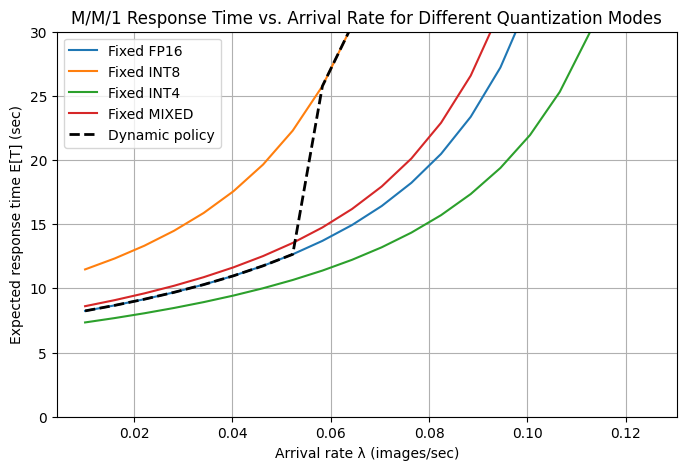

In [12]:
# === CELL: M/M/1 queueing model based on measured latencies ===
import numpy as np
import matplotlib.pyplot as plt

def service_rate_from_latency(latency_s: float) -> float:
    """Service rate μ (jobs per second) from mean latency per image."""
    return 1.0 / latency_s if latency_s > 0 else 0.0

service_rates = {
    mode: service_rate_from_latency(results[mode]["latency"])
    for mode in ["fp16", "int8", "int4", "mixed"]
}

print("Service rates (μ in images/sec):")
for mode, mu in service_rates.items():
    print(f"{mode.upper()}: μ ≈ {mu:.3f}")


def mm1_response_time(lam: float, mu: float) -> float:
    """
    M/M/1 expected response time:
    E[T] = 1 / (μ - λ),  valid only for λ < μ (stable system).
    """
    if lam >= mu:
        return float("inf")
    return 1.0 / (mu - lam)


def choose_mode_dynamic(lam: float, service_rates: dict) -> str:
    """
    Simple dynamic precision policy:
    - For low load, prefer high quality (FP16).
    - For medium load, use INT8.
    - For high load, use mixed or INT4.

    Here we define thresholds based on the FP16 capacity.
    """
    mu_fp16 = service_rates["fp16"]
    if mu_fp16 <= 0:
        # fallback: if FP16 is not valid, just pick INT8
        return "int8"

    rho = lam / mu_fp16  # utilisation relative to FP16 capacity

    if rho < 0.4:
        return "fp16"
    elif rho < 0.7:
        return "int8"
    elif rho < 0.9:
        return "mixed"
    else:
        return "int4"


# Sweep arrival rates from very low up to close to FP16 capacity
max_lambda = service_rates["fp16"] * 0.95 if service_rates["fp16"] > 0 else 1.0
lambda_values = np.linspace(0.01, max_lambda, 20)

response_fixed = {mode: [] for mode in ["fp16", "int8", "int4", "mixed"]}
response_dynamic = []

for lam in lambda_values:
    # Fixed modes
    for mode in response_fixed:
        mu = service_rates[mode]
        T = mm1_response_time(lam, mu) if mu > 0 and lam < mu else float("inf")
        response_fixed[mode].append(T)

    # Dynamic mode
    chosen_mode = choose_mode_dynamic(lam, service_rates)
    mu_chosen = service_rates[chosen_mode]
    T_dyn = mm1_response_time(lam, mu_chosen) if mu_chosen > 0 and lam < mu_chosen else float("inf")
    response_dynamic.append(T_dyn)


# Plot theoretical response times
plt.figure(figsize=(8, 5))
for mode, curve in response_fixed.items():
    plt.plot(lambda_values, curve, label=f"Fixed {mode.upper()}")

plt.plot(lambda_values, response_dynamic, "k--", linewidth=2.0, label="Dynamic policy")

plt.xlabel("Arrival rate λ (images/sec)")
plt.ylabel("Expected response time E[T] (sec)")
plt.title("M/M/1 Response Time vs. Arrival Rate for Different Quantization Modes")
plt.ylim(0, min(30, max([c for curve in response_fixed.values() for c in curve if np.isfinite(c)] + response_dynamic)))
plt.grid(True)
plt.legend()
plt.show()


## Conclusion

This notebook successfully reproduces the essential ideas of Q-Diffusion using the Diffusers library:

- Implemented timestep-aware activation calibration  
- Added fake quantization (INT8, INT4, mixed) to all UNet Conv2d layers  
- Measured latency, memory, and quality impact per mode  
- Modeled system-level behavior using an M/M/1 queue  
- Showed how dynamic precision policies can adapt to load conditions

The results align with our **project proposal** and demonstrate how quantization can significantly improve inference efficiency while enabling intelligent runtime switching policies.


## Limitations

- Fake quantization instead of true hardware INT4 kernels

- Calibration only on a small prompt set

- Stable Diffusion v1.5 is heavy; future work could use smaller models